In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [20]:
data = pd.read_csv('GOOG.csv')
Date1 = data['Date']
Price_G = data['Open']
vol = data['Volume']
p_500 = data['SP500']
btc = data['BTC']
new_data = []
new_data.append(pd.DataFrame({'Date':Date1,
                              'Google': Price_G,
                              
                              'S&P500': p_500,
                              'BTC': btc
                              }))
new_data_df = pd.concat(new_data)
new_data_df.dropna(inplace=True)
new_data_df.info()
new_data_df['Date'] = pd.to_datetime(new_data_df['Date'])  # Ensure the date column is in datetime format
df = new_data_df.set_index('Date')  # Set the date column as the index of the DataFrame

<class 'pandas.core.frame.DataFrame'>
Index: 2090 entries, 0 to 2089
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2090 non-null   object 
 1   Google  2090 non-null   float64
 2   S&P500  2090 non-null   float64
 3   BTC     2090 non-null   float64
dtypes: float64(3), object(1)
memory usage: 81.6+ KB


In [21]:
# Agregați datele în time frame-uri săptămânale
df_weekly = df.resample('W').mean()  # puteți utiliza și alte metode de agregare, cum ar fi 'sum', 'max', 'min', etc.
df = df_weekly
df = df.drop(df.index[0])

# Vizualizați DataFrame-ul rezultat cu time frame-uri săptămânale
print(df)

                Google     S&P500         BTC
Date                                         
2015-01-11   25.410336  2035.2400    280.4580
2015-01-18   24.871814  2020.4220    228.6800
2015-01-25   25.870473  2034.5575    221.2825
2015-02-01   26.109716  2030.4840    251.3440
2015-02-08   26.331706  2034.7940    227.2060
...                ...        ...         ...
2023-03-26  103.961999  3958.7640  27918.9560
2023-04-02  102.838000  4011.9020  27755.2780
2023-04-09  104.849998  4101.5775  28080.8275
2023-04-16  107.172000  4111.4720  29704.7180
2023-04-23  105.476999  4140.6760  29446.6680

[433 rows x 3 columns]


In [22]:
data_2 = pd.read_csv('WALCL.csv')
Date1_2 = data_2['Date']
Price_2 = data_2['WALCL']
new_data_2 = []
new_data_2.append(pd.DataFrame({'Date':Date1_2,
                              'FED_Balance': Price_2
                              }))
new_data_df_2 = pd.concat(new_data_2)
new_data_df_2.dropna(inplace=True)
new_data_df_2.info()
new_data_df_2['Date'] = pd.to_datetime(new_data_df_2['Date'])  # Ensure the date column is in datetime format
df_2 = new_data_df_2.set_index('Date')  # Set the date column as the index of the DataFrame

# Agregați datele în time frame-uri săptămânale
df_weekly_2 = df_2.resample('W').mean()  # puteți utiliza și alte metode de agregare, cum ar fi 'sum', 'max', 'min', etc.
df_2 = df_weekly_2

# Vizualizați DataFrame-ul rezultat cu time frame-uri săptămânale
print(df_2)

<class 'pandas.core.frame.DataFrame'>
Index: 437 entries, 0 to 436
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         437 non-null    object 
 1   FED_Balance  437 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.2+ KB
            FED_Balance
Date                   
2015-01-11    4499524.0
2015-01-18    4516077.0
2015-01-25    4512936.0
2015-02-01    4500064.0
2015-02-08    4500348.0
...                 ...
2023-04-23    8593263.0
2023-04-30    8562768.0
2023-05-07    8503994.0
2023-05-14    8503017.0
2023-05-21    8456760.0

[437 rows x 1 columns]


In [23]:
merged_df = df.merge(df_2, on='Date', how='outer')

In [24]:
df = merged_df.dropna()

In [25]:
df = df.astype(int)

In [26]:
df.head()

,Google,S&P500,BTC,FED_Balance
Date,,,,
2015-01-11,25,2035,280,4499524
2015-01-18,24,2020,228,4516077
2015-01-25,25,2034,221,4512936
2015-02-01,26,2030,251,4500064
2015-02-08,26,2034,227,4500348


In [37]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [120]:
# Normalizarea datelor pentru caracteristici
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[df.columns[1:]])

# Normalizarea datelor pentru etichetă
scaler_label = MinMaxScaler(feature_range=(0, 1))
scaled_label = scaler_label.fit_transform(df['Google'].values.reshape(-1,1))

# Înlocuiește coloana de deschidere în scaled_data cu scaled_label
scaled_data[:,0] = scaled_label.flatten()

# Împărțire date în train și test
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Pregătire date pentru LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Creare model LSTM
model = Sequential()
model.add(LSTM(5,activation='tanh', return_sequences=True, input_shape=(look_back, X_train.shape[2]))) 
model.add(LSTM(5,activation='tanh', return_sequences=True)) 
model.add(LSTM(5,activation='relu', return_sequences=True)) 
model.add(LSTM(5,activation='relu', return_sequences=True)) 
model.add(LSTM(5,activation='relu', return_sequences=True)) 
model.add(LSTM(5,activation='relu', return_sequences=True)) 
model.add(LSTM(5, activation='tanh')) 
model.add(Dense(1, activation='relu')) # layer de ieșire

# Compilare model
model.compile(loss='mean_squared_error', optimizer='adam')

# Antrenare model și salvare istoric antrenare
history = model.fit(X_train, Y_train, epochs=20, batch_size=5, verbose=1)

# Predicții
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Schimbă forma predicțiilor pentru a elimina dimensiunea pasului de timp
train_predict = train_predict.flatten()
test_predict = test_predict.flatten()

# Inversare transformare pentru a reveni la scala originală
train_predict = scaler_label.inverse_transform(train_predict.reshape(-1, 1))
Y_train = scaler_label.inverse_transform(Y_train.reshape(-1, 1))

test_predict = scaler_label.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler_label.inverse_transform(Y_test.reshape(-1, 1))

# Aplatizare predicții
train_predict = train_predict.flatten()
test_predict = test_predict.flatten()

# Calculare eroare medie pătratică
train_score = math.sqrt(mean_squared_error(Y_train, train_predict[:len(Y_train)]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(Y_test, test_predict[:len(Y_test)]))
print('Test Score: %.2f RMSE' % (test_score))

Epoch 1/20
65/65 [==============================] - 7s 13ms/step - loss: 0.0556
Epoch 2/20
65/65 [==============================] - 1s 15ms/step - loss: 0.0277
Epoch 3/20
65/65 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 4/20
65/65 [==============================] - 1s 13ms/step - loss: 0.0020
Epoch 5/20
65/65 [==============================] - 1s 13ms/step - loss: 0.0017
Epoch 6/20
65/65 [==============================] - 1s 14ms/step - loss: 0.0017
Epoch 7/20
65/65 [==============================] - 1s 14ms/step - loss: 0.0017
Epoch 8/20
65/65 [==============================] - 1s 13ms/step - loss: 0.0018
Epoch 9/20
65/65 [==============================] - 1s 14ms/step - loss: 0.0015
Epoch 10/20
65/65 [==============================] - 1s 14ms/step - loss: 0.0014
Epoch 11/20
65/65 [==============================] - 1s 14ms/step - loss: 0.0014
Epoch 12/20
65/65 [==============================] - 1s 14ms/step - loss: 0.0016
Epoch 13/20
65/65 [==================

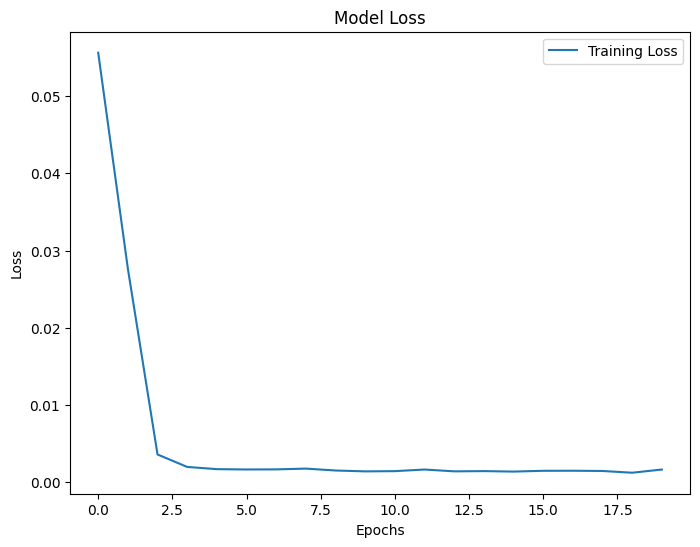

In [121]:
# Afisare evolutie RMSE pe parcursul antrenarii
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

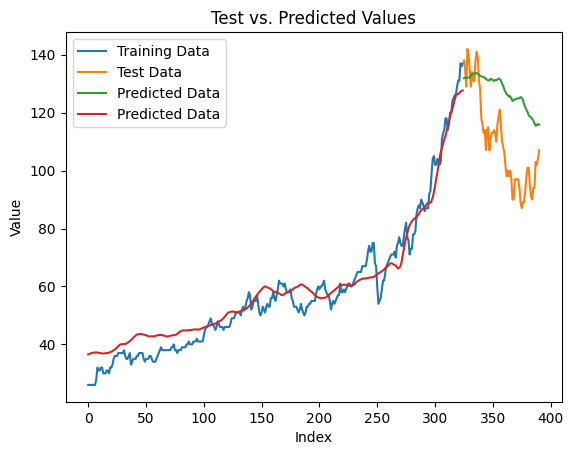

In [122]:
train_length = len(Y_train)
test_length = len(Y_test)

plt.plot(range(train_length), Y_train, label='Training Data')
plt.plot(range(train_length, train_length + test_length), Y_test, label='Test Data')
plt.plot(range(train_length, train_length + test_length), test_predict, label='Predicted Data')
plt.plot(range(train_length), train_predict, label='Predicted Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Test vs. Predicted Values')
plt.legend()

plt.show()